# Logistic Regression
> Based on Coursera Machine Learning course assignments.

In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from scipy import optimize
import pandas as pd
import matplotlib.pyplot as plt
import math
from logistic_regression import *
from utils import *

In [3]:
# load data
data1 = pd.read_csv("../data/ex2data1.csv",
                  names=["Exam A", "Exam B", "Admission"])
print(data1.head())
print(data1.shape)

      Exam A     Exam B  Admission
0  34.623660  78.024693          0
1  30.286711  43.894998          0
2  35.847409  72.902198          0
3  60.182599  86.308552          1
4  79.032736  75.344376          1
(100, 3)


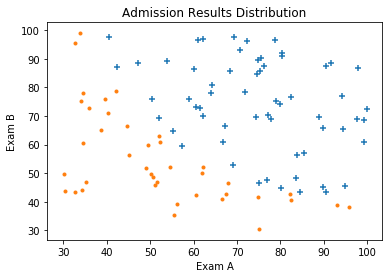

In [4]:
# scatter plot with admitted and not admitted students
def plot_data1():
    admitted = data1.loc[data1["Admission"] == 1]
    not_admitted = data1.loc[data1["Admission"] == 0]

    plt.scatter(admitted[["Exam A"]], admitted[["Exam B"]], marker="+")
    plt.scatter(not_admitted[["Exam A"]], not_admitted[["Exam B"]], marker=".")
    plt.xlabel("Exam A")
    plt.ylabel("Exam B")
    plt.title("Admission Results Distribution")
    
plot_data1()
plt.show()

## Hypothesis

Split data with logistic function:

$$h(X^{(i)}) = \frac{1}{1 + e^{-z}}$$

Where: 

$$z = \theta_0 x_0^{(i)} + \theta_1 x_1^{(i)} + ... + \theta_n x_n^{(i)} = \Theta^T X^{(i)} $$

$h(X^{(i)})$ ranges from 0 to 1 inclusive, represents probability $P(y = 1)$ of positive outcome.

Positive ($y = 1$) when $h(X^{(i)}) \ge 0.5; z \ge 0$

Negative ($y = 0$) when $h(X^{(i)}) \lt 0.5; z \lt 0$


In [5]:
# %load -s sigmoid ../logistic_regression.py
def sigmoid(z):
    """
    Calculate sigmoid function

    @param z: vector, e^z
    @return: vector of sigmoid function results
    """
    return 1 / (1 + np.power(math.e, -z))


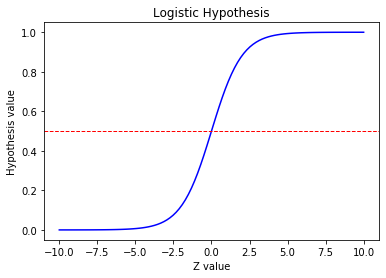

In [6]:
# plot logistic hypothesis function
z = np.linspace(-10, 10, 100)
h = [sigmoid(val) for val in z]
plt.plot(z, h, "-b")
plt.axhline(0.5, color='r', ls="--", lw=1)
plt.xlabel("Z value")
plt.ylabel("Hypothesis value")
plt.title("Logistic Hypothesis")
plt.show()

## Cost Function
Find vector of $\Theta$ parameters which minimize $J(\Theta)$ function:

$$J(\Theta) = - \frac{1}{m} \sum_{i=0}^{m} { y^{(i)} log(h(X^{(i)})) 
                       + (1 - y^{(i)}) log(1 - h(X^{(i)})) }$$

In [7]:
# %load -s cost_function ../logistic_regression.py
def cost_function(coefficients, x, y):
    """
    Calculate cost function for logistic regression

    @param coefficients: (1 x n) vector of regression coefficients
    @param x: (m x n) matrix, m - experiments count, n - variables count
    @param y: (m x 1) results vector
    @return: summary cost
    """
    coefficients = coefficients.reshape(coefficients.size, 1)

    return - 1 / y.size * (
            y.transpose() @ np.log(sigmoid(x @ coefficients))
            +
            (1 - y).transpose() @ np.log(1 - sigmoid(x @ coefficients))
    )[0, 0]


First derivative of the logistic cost function looks simillar to the one in *Linear Regression*:

$$ \theta_j = \theta_j - \alpha \frac{dJ}{d\theta_j} 
            = \theta_j - \alpha \frac{1}{m} \sum_{i=0}^{m} (h(X^{(i)}) - y^{(i)})x^{(i)}_j $$

In [ ]:
# %load -s cost_function_derivative ../logistic_regression.py
def cost_function_derivative(coefficients, x, y):
    """
    Calculate cost function first derivative dJ/dC for each coefficient

    @param coefficients: (1 x n) coefficients vector
    @param x: input variables (m x (n - 1)) matrix,
              n - variables count, m - experiments count
    @param y: results (m x 1) vector, m - experiments count
    @return: (n x 1) vector of derivative calculation results for each coefficient
    """
    coefficients = coefficients.reshape(coefficients.size, 1)

    return 1 / y.size * np.dot(
        np.subtract(
            sigmoid(x @ coefficients),
            y
        ).transpose(),  # 1 x m
        x  # m x n
    )[0]


## Optimization

Using BFGS algorithm to minimize coefficients. 

In [9]:
# find coefficients using BFGS
x1 = concat_with_x0(data1[["Exam A", "Exam B"]]).values
y1 = data1[["Admission"]].values

np.seterr(divide = 'ignore', invalid = 'ignore')
coefficients = optimize.fmin_bfgs(cost_function, 
                                  np.zeros(x1.shape[1]), 
                                  cost_function_derivative, 
                                  args=(x1, y1))
print(coefficients)

Optimization terminated successfully.
         Current function value: 0.203498
         Iterations: 23
         Function evaluations: 31
         Gradient evaluations: 31
[-25.16133284   0.2062317    0.2014716 ]


To identify decision boundary with given coefficients, need to solve the following equation:

$h(X^{(i)}) = 0.5$ when $z = 0$, thus $z = \Theta^T X = 0$

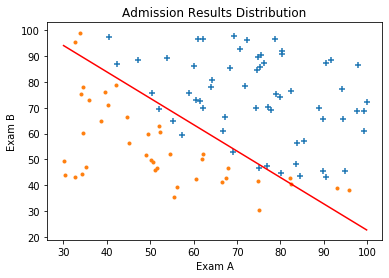

In [10]:
# plot decision boundary
x1_1 = [np.min(data1["Exam A"]), np.max(data1["Exam A"])]
x1_2 = [- (coefficients[0] + coefficients[1] * x) / coefficients[2] for x in x1_1]
plot_data1()
plt.plot(x1_1, x1_2, "-r")
plt.show()

# Regularized Logistic Regression

In [11]:
# load data
data2 = pd.read_csv("../data/ex2data2.csv",
                  names=["Test 1", "Test 2", "QA"])
print(data2.head())
print(data2.shape)

     Test 1   Test 2  QA
0  0.051267  0.69956   1
1 -0.092742  0.68494   1
2 -0.213710  0.69225   1
3 -0.375000  0.50219   1
4 -0.513250  0.46564   1
(118, 3)


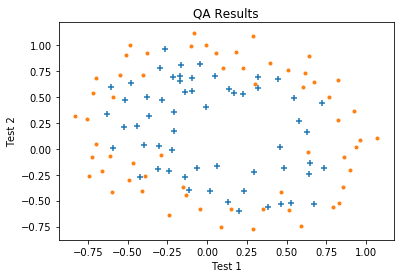

In [12]:
# scatter plot with admitted and not admitted students
def plot_data2():
    passed = data2.loc[data2["QA"] == 1]
    failed = data2.loc[data2["QA"] == 0]

    plt.scatter(passed[["Test 1"]], passed[["Test 2"]], marker="+")
    plt.scatter(failed[["Test 1"]], failed[["Test 2"]], marker=".")
    plt.xlabel("Test 1")
    plt.ylabel("Test 2")
    plt.title("QA Results")
    
plot_data2()
plt.show()

## Feature Mapping

Linear decision boundary doesn't work in this case. Will introduce feature mapping function to use polynomial features.

$$mapFeatures(x_1, x_2) = \{1, x_1, x_2, x_1^2, x_1 x_2, x_2^2, ..., x_1 x_2^5, x_2^6\}$$

In [13]:
def mapFeatures(x1, x2, degree):
    """
    Map features to polynomial 
    
    @param x1: (m x 1) vector of variable x1 values
    @param x2: (m x 1) vector of variable x2 values
    @param degree: polynomial degree
    @return: (m x N) matrix with N polynomial features
    """
    return np.concatenate([[np.power(x1, i - j) * np.power(x2, j)
     for j in range(i + 1)] 
     for i in range(1, degree + 1)]).transpose()[0]

## Regularized Cost Function

Adding extra parameters sum to the cost function $J(\Theta)$:

$$J_{reg}(\Theta) = J(\Theta) + \frac{\lambda}{2 m} \sum_{j=1}^n \theta_j^2$$

Where $\lambda$ is regularization rate and $\theta_0$ is skipped.

Gradient and first derivative:

$$ \theta_j = \theta_j - \alpha \frac{dJ_{reg}}{d\theta_j} \\
            = \theta_j - \alpha (
                \frac{1}{m} \sum_{i=0}^{m} (h(X^{(i)}) - y^{(i)})x^{(i)}_j 
                + \frac{\lambda}{m}\theta_j ) \\
            = \theta_j (1 - \frac{\alpha \lambda}{m}) 
                - \alpha \frac{1}{m} \sum_{i=0}^{m} (h(X^{(i)}) - y^{(i)})x^{(i)}_j $$
                
So $\theta_j$ will be less with each gradient iteration. As the result some features may be considered insignificant.

In [14]:
# %load -s regularized_cost_function ../logistic_regression.py
def regularized_cost_function(coefficients, x, y,
                              regularization_rate: float):
    c = np.reshape(coefficients[1:coefficients.size], (coefficients.size - 1, 1))

    return cost_function(coefficients, x, y) \
           + regularization_rate / (2 * y.size) * (c.transpose() @ c)[0, 0]


In [15]:
# %load -s regularized_cost_function_derivative ../logistic_regression.py
def regularized_cost_function_derivative(coefficients, x, y,
                                         regularization_rate: float):
    c = np.concatenate([[0], coefficients[1:coefficients.size]])

    return cost_function_derivative(coefficients, x, y) \
           + regularization_rate / y.size * c


In [16]:
# find optimal coefficients
polynomial_degree = 6
x2_mapped = mapFeatures(data2[["Test 1"]].values, data2[["Test 2"]].values, polynomial_degree)
x2_mapped = np.concatenate([np.ones((x2_mapped.shape[0], 1)), x2_mapped], axis=1)
y2 = data2[["QA"]].values
regularization_rate = 1

coefficients = optimize.fmin_bfgs(regularized_cost_function, 
                                  np.zeros(x2_mapped.shape[1]), 
                                  regularized_cost_function_derivative, 
                                  args=(x2_mapped, y2, regularization_rate))
print(coefficients)

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 48
[ 1.27268739  0.62557016  1.1809665  -2.01919822 -0.91761468 -1.43194199
  0.12375921 -0.36513086 -0.35703388 -0.17485805 -1.45843772 -0.05129676
 -0.61603963 -0.2746414  -1.19282569 -0.24270336 -0.20570022 -0.04499768
 -0.27782709 -0.29525851 -0.45613294 -1.04377851  0.02762813 -0.29265642
  0.01543393 -0.32759318 -0.14389199 -0.92460119]


In [17]:
# calculate model accuracy by comparing model outcomes with original ones 
pred = [sigmoid(x2_mapped @ coefficients) >= 0.5]
print(np.mean(pred == y2.flatten()) * 100)

83.05084745762711


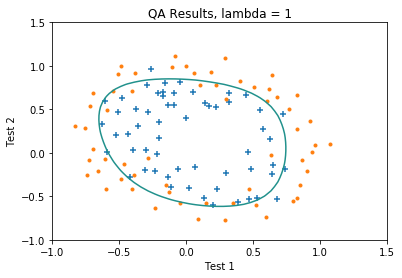

In [21]:
# plot decision boundary
t1 = np.linspace(-1, 1.5, 50)
t2 = np.linspace(-1, 1.5, 50)

z = np.array([[coefficients @ \
               np.concatenate([[1], mapFeatures([t1[i]], [t2[j]], polynomial_degree)])
      for j in range(t2.size)]
     for i in range(t1.size)]).transpose()
        
plot_data2()
plt.contour(t1, t2, z, 0)
plt.title("QA Results, lambda = " + str(regularization_rate))
plt.show()